In [1]:
import numpy as np
import do_mpc

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [3]:
δ = model.set_variable(var_type='_u', var_name='δ', shape=(1,1))
δ_m = model.set_variable(var_type='_x', var_name='δ_m', shape=(1,1))
r = model.set_variable(var_type='_x', var_name='r', shape=(1,1))
dr = model.set_variable(var_type='_x', var_name='dr', shape=(1,1))

In [4]:
K = model.set_variable(var_type='_p', var_name='K')
T = model.set_variable(var_type='_p', var_name='T')

In [5]:
model.set_rhs('r', dr)

In [6]:
from casadi import *

In [7]:
dr_next = vertcat(
    1.0 / T * (- r + K * δ )
)
model.set_rhs('dr', dr_next)

In [8]:
model.set_rhs('δ_m', δ - δ_m)

In [9]:
model.setup()

In [10]:
mpc = do_mpc.controller.MPC(model)

In [11]:
setup_mpc = {
    'n_horizon': 200,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [12]:
target_r = 0.00050
mterm = (r - target_r)**2
lterm = (r - target_r)**2
mpc.set_objective(mterm=mterm, lterm=lterm)

In [13]:
mpc.set_rterm(
    δ = 1e-3
)

In [14]:
mpc.bounds['lower','_u', 'δ'] = - 30 * np.pi / 180
mpc.bounds['upper','_u', 'δ'] = 30 * np.pi / 180

In [15]:
mpc.set_uncertainty_values(
    K = 0.15 * np.array([1., 0.95, 1.05]),
    T = 80.0 * np.array([1., 0.90, 1.10]),
)

In [16]:
mpc.setup()

In [17]:
simulator = do_mpc.simulator.Simulator(model)

In [18]:
simulator.set_param(t_step = 0.1)

In [19]:
p_template = simulator.get_p_template()

In [20]:
p_template.keys()

['default', 'K', 'T']

In [21]:
def p_fun(t_now):
    p_template['K'] = 0.15
    p_template['T'] = 80.0
    return p_template

In [22]:
simulator.set_p_fun(p_fun)

In [23]:
simulator.setup()

In [24]:
mpc.set_initial_guess()

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [26]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [27]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [28]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    g.add_line(var_type='_x', var_name='r', axis=ax[0])
    g.add_line(var_type='_u', var_name='δ', axis=ax[1])


ax[0].set_ylabel('rate_of_turn [rad/s]')
ax[1].set_ylabel('delta [rad]')
ax[1].set_xlabel('time [s]')

In [29]:
u0 = np.zeros((1,1))
for i in range(200):
    simulator.make_step(u0)

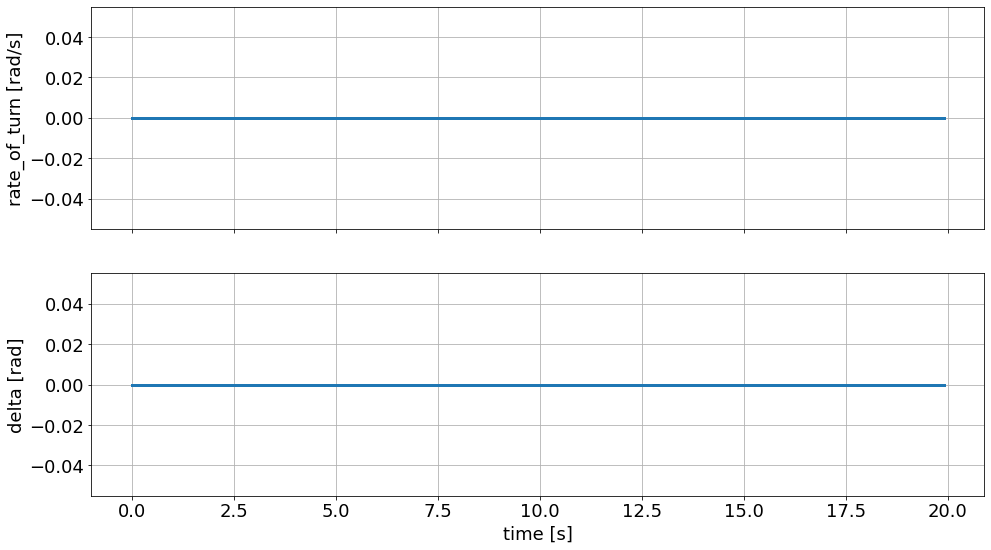

In [30]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig

In [31]:
u0 = mpc.make_step(mpc.x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    68403
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5384

Total number of variables............................:    23508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1800
                     variables with only upper bounds:        0
Total number of equa

In [32]:
sim_graphics.clear()

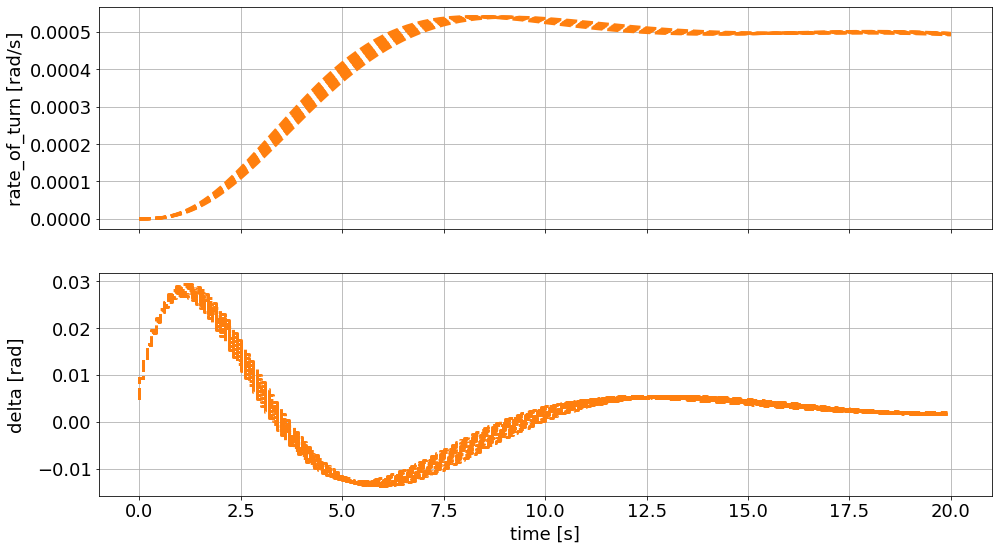

In [33]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig